# LightGBM

In [112]:
# pip install xgboost

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split 
import lightgbm as lgb
import xgboost as xgb
from hyperopt import fmin, tpe, hp, partial, Trials, space_eval, STATUS_OK
from sklearn.preprocessing import LabelEncoder
import gc

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from functools import partial
from pprint import pprint
import numpy as np
from hyperopt.pyll import scope, stochastic
from plotly import express as px
from plotly import graph_objects as go
from plotly import offline as pyo
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.utils import check_random_state

In [16]:
# label encoder
data = pd.read_csv('data_clear.csv', index_col=0)
for col in data.select_dtypes('object').columns:
    if col not in ['user']:
        lbl = LabelEncoder()
        data[col] = lbl.fit_transform(data[col].astype(str))


train = data[~data['label'].isnull()]
X = train.drop(columns=['user', 'label'], axis=1)
y = train.loc[:, 'label']

In [15]:
# count encoder
import category_encoders as ce
data = pd.read_csv('data_clear.csv', index_col=0)
for col in data.select_dtypes('object').columns:
    if col not in ['user']:
        count_e = ce.CountEncoder()
        data[col] = count_e.fit_transform(data[col].astype(str))


train = data[~data['label'].isnull()]
X = train.drop(columns=['user', 'label'], axis=1)
y = train.loc[:, 'label']

In [36]:
# target encoder
import category_encoders as ce

data = pd.read_csv('data_clear.csv', index_col=0)

train = data[~data['label'].isnull()]
temp_x = train.drop(columns=['user', 'label'], axis=1)
temp_y = train.loc[:, 'label']

cat_features = temp_x.select_dtypes('object').columns

target_enc = ce.TargetEncoder(cols=cat_features)
target_enc.fit(temp_x[cat_features], temp_y)

data[cat_features] = target_enc.transform(data[cat_features])

train = data[~data['label'].isnull()]
X = train.drop(columns=['user', 'label'], axis=1)
y = train.loc[:, 'label']

In [43]:
# cat boost encoder
import category_encoders as ce

data = pd.read_csv('data_clear.csv', index_col=0)

train = data[~data['label'].isnull()]
temp_x = train.drop(columns=['user', 'label'], axis=1)
temp_y = train.loc[:, 'label']

cat_features = temp_x.select_dtypes('object').columns

catbst_enc = ce.CatBoostEncoder(cols=cat_features)
catbst_enc.fit(temp_x[cat_features], temp_y)

data[cat_features] = catbst_enc.transform(data[cat_features])

train = data[~data['label'].isnull()]
X = train.drop(columns=['user', 'label'], axis=1)
y = train.loc[:, 'label']

In [ ]:
seed=623

In [30]:
# prepare the test set for the final evaluation

# test_X = data[data['label'].isnull()]
# test_y = pd.read_csv('test_label_new.csv', index_col=0)
# test = pd.merge(test_X, test_y, on='user')
# test.shape

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=623)
train_data = lgb.Dataset(data=x_train,label=y_train)
test_data = lgb.Dataset(data=x_test,label=y_test)

In [22]:
df_train = train
df_test = data[data.label.isnull()].copy()

In [172]:
# # optimal parameters
# {'feature_fraction': 0.59, 
#  'learning_rate': 0.08748742858194956, 
#  'max_depth': 14, 
#  'num_leaves': 25, 
#  'reg_alpha': 10, 
#  'reg_lambda': 13, 
#  'sub_sample': 0.56}

In [15]:
ycol = 'label'
feature_names = list(filter(lambda x: x not in [ycol, 'user'], df_train.columns))

model = lgb.LGBMClassifier(objective='binary',
                           boosting_type='gbdt',
                           num_leaves=25,
                           max_depth=14,
                           learning_rate=0.01,
                           n_estimators=10000,
                           subsample=0.56,
                           feature_fraction=0.59,
                           reg_alpha=10,
                           reg_lambda=13,
                           random_state=seed,
                           is_unbalance=True,
                           metric='auc')

df_oof = df_train[['user', ycol]].copy()
df_oof['prob'] = 0
prediction = df_test[['user']]
prediction['prob'] = 0
df_importance_list = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for fold_id, (trn_idx, val_idx) in enumerate(kfold.split(df_train[feature_names], df_train[ycol])):
    X_train = df_train.iloc[trn_idx][feature_names]
    Y_train = df_train.iloc[trn_idx][ycol]

    X_val = df_train.iloc[val_idx][feature_names]
    Y_val = df_train.iloc[val_idx][ycol]

    print('\nFold_{} Training ================================\n'.format(
        fold_id + 1))

    lgb_model = model.fit(X_train,
                          Y_train,
                          eval_names=['train', 'valid'],
                          eval_set=[(X_train, Y_train), (X_val, Y_val)],
                          verbose=100,
                          early_stopping_rounds=50)

    pred_val = lgb_model.predict_proba(X_val, num_iteration=lgb_model.best_iteration_)[:, 1]
    df_oof.loc[val_idx, 'prob'] = pred_val

    pred_test = lgb_model.predict_proba(df_test[feature_names], num_iteration=lgb_model.best_iteration_)[:, 1]
    prediction['prob'] += pred_test / kfold.n_splits

    df_importance = pd.DataFrame({
        'column': feature_names,
        'importance': lgb_model.feature_importances_,
    })
    df_importance_list.append(df_importance)

    del lgb_model, pred_val, pred_test, X_train, Y_train, X_val, Y_val
    gc.collect()

<ipython-input-15-656aac5b4e82>:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_1 Training ================================

Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.751552	valid's auc: 0.713689
[200]	train's auc: 0.769773	valid's auc: 0.723096
[300]	train's auc: 0.784744	valid's auc: 0.729543
[400]	train's auc: 0.79825	valid's auc: 0.734449
[500]	train's auc: 0.810699	valid's auc: 0.737124
[600]	train's auc: 0.821704	valid's auc: 0.738856
[700]	train's auc: 0.831934	valid's auc: 0.739529
[800]	train's auc: 0.84137	valid's auc: 0.740137
[900]	train's auc: 0.850216	valid's auc: 0.740267
[1000]	train's auc: 0.858348	valid's auc: 0.740546
Early stopping, best iteration is:
[1010]	train's auc: 0.859125	valid's auc: 0.740584


<ipython-input-15-656aac5b4e82>:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_2 Training ================================

[LightGBM] [Warning] feature_fraction is set=0.59, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.59
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.751234	valid's auc: 0.711834
[200]	train's auc: 0.769576	valid's auc: 0.721076
[300]	train's auc: 0.784955	valid's auc: 0.726951
[400]	train's auc: 0.79821	valid's auc: 0.730975
[500]	train's auc: 0.810346	valid's auc: 0.733679
[600]	train's auc: 0.821202	valid's auc: 0.735309
[700]	train's auc: 0.831181	valid's auc: 0.736203
[800]	train's auc: 0.840497	valid's auc: 0.736728
[900]	train's auc: 0.849089	valid's auc: 0.737114
[1000]	train's auc: 0.857257	valid's auc: 0.737206
Early stopping, best iteration is:
[956]	train's auc: 0.853726	valid's auc: 0.737272

Fold_3 Training ================================

[LightGBM] [Warning] feature_fraction is set=0.59, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.59


In [16]:
pred_lgb = prediction
prediction.head()

,user,prob
38225,Train_08221,0.708626
38226,Train_23216,0.552637
38227,Train_29740,0.216002
38228,Train_11378,0.555413
38229,Train_09309,0.553888


In [17]:
test_y = pd.read_csv('test_label_new.csv', index_col=0)
test_y.head()

,user,label
0,Train_08043,1
1,Train_28969,0
2,Train_09002,1
3,Train_05608,1
4,Train_25993,0


In [18]:
test = pd.merge(test_y,prediction, on='user')
test.head()

,user,label,prob
0,Train_08043,1,0.356830
1,Train_28969,0,0.007907
2,Train_09002,1,0.603931
3,Train_05608,1,0.553786
4,Train_25993,0,0.569870


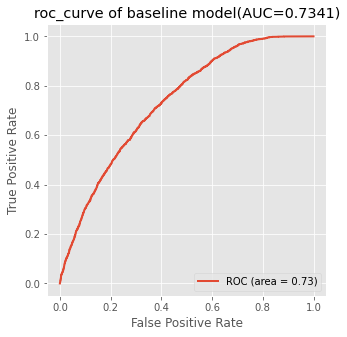

In [19]:
gbm_fpr,gbm_tpr,gbm_threasholds=roc_curve(test.iloc[:,1],test.iloc[:,2]) # 计算ROC的值,svm_threasholds为阈值

roc_auc = auc(gbm_fpr, gbm_tpr)

plt.figure(figsize=(5, 5))
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.title("roc_curve of %s(AUC=%.4f)" %('baseline model',roc_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(gbm_fpr,gbm_tpr, label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.legend(loc="lower right")
plt.savefig("baseline_roc.png")

In [20]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby(['column'])['importance'].agg('mean').sort_values(ascending=False).reset_index()

df_importance_top20 = df_importance.sort_values(by="importance", ascending=False).iloc[0:20,:]
df_importance_top100 = df_importance.sort_values(by="importance", ascending=False).iloc[0:100,:]
# print(df_importance_top100.iloc[:,0].tolist())

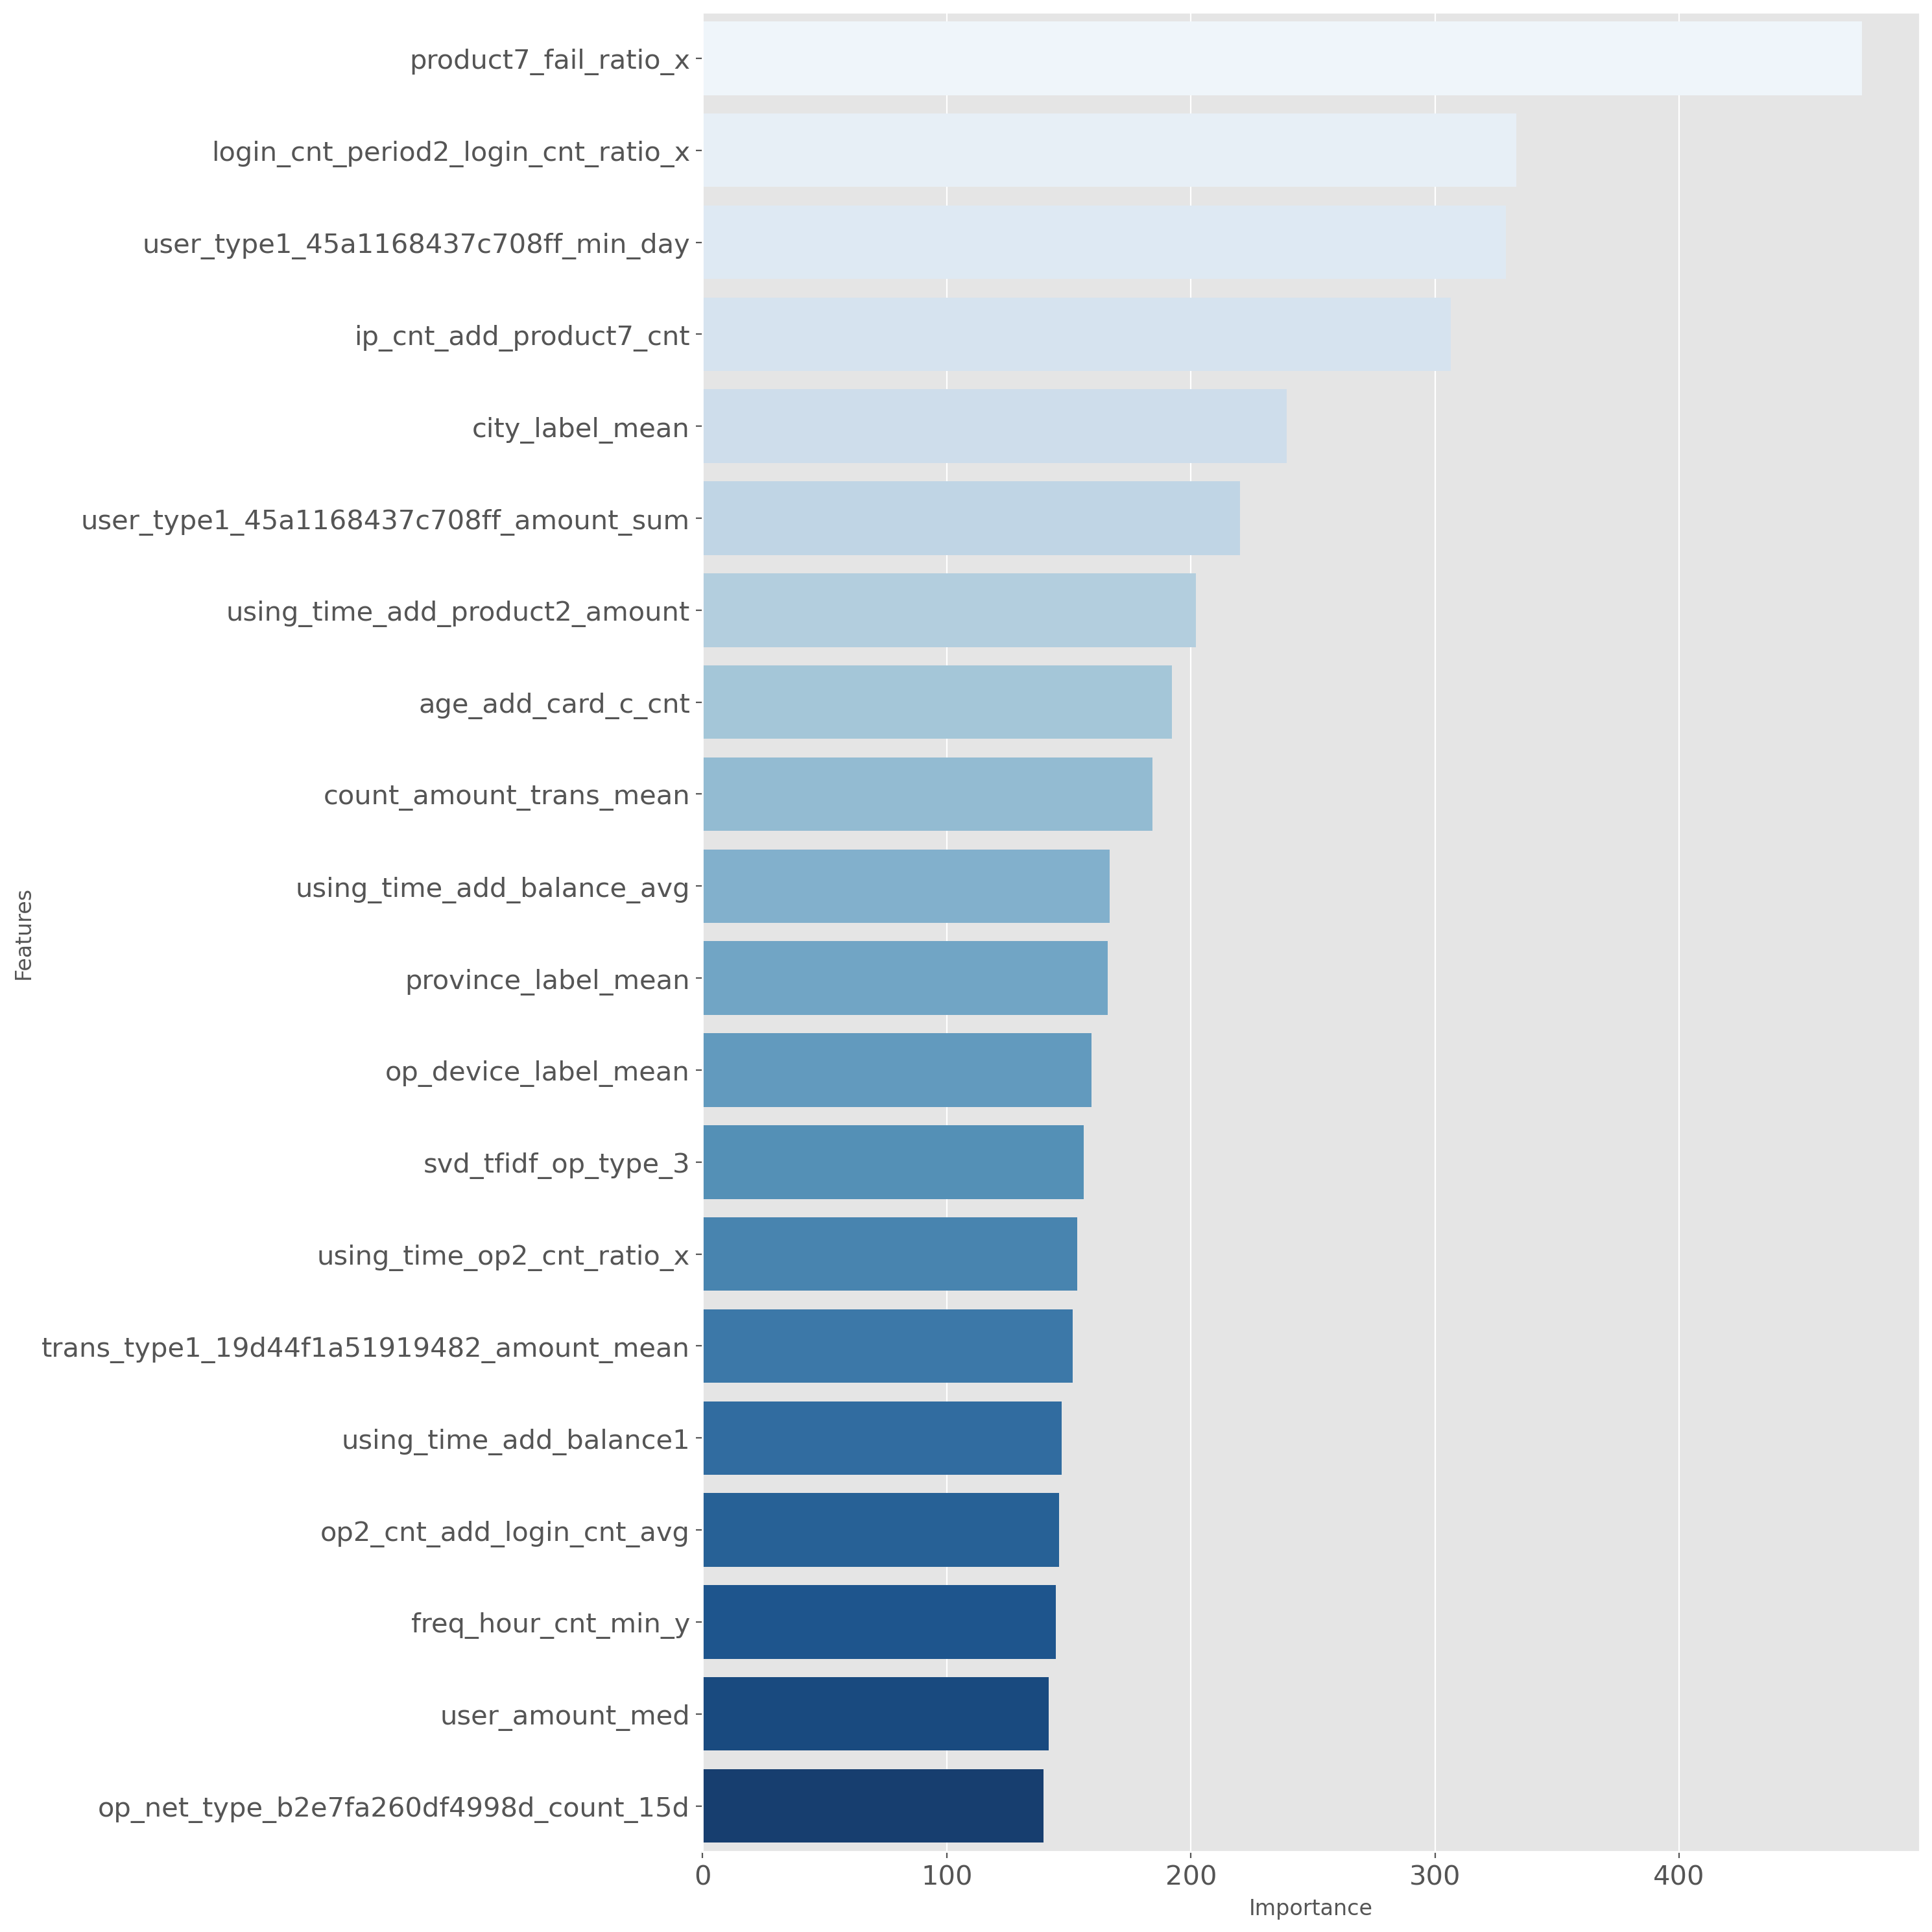

In [21]:
# feature importance visualization

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
# feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 15))
sns.barplot(x="importance", y="column", data=df_importance_top20, palette='Blues' ) 
# plt.title('LightGBM Features (avg over folds)')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.xlabel('Importance')
plt.ylabel('Features')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
# plt.show()
plt.savefig('lgbm_importances.png')

# XGBoost

In [ ]:
%%time
ycol = 'label'
feature_names = list(
    filter(lambda x: x not in [ycol, 'user'], df_train.columns))

model = xgb.XGBClassifier( 
                           max_depth=6,
                           learning_rate=0.01,
                           n_estimators=10000,
                           subsample=0.8,
                           reg_alpha=10,
                           reg_lambda=12,
#                             tree_method='gpu_hist',
                           random_state=seed)

df_oof = df_train[['user', ycol]].copy()
df_oof['prob'] = 0
prediction = df_test[['user']]
prediction['prob'] = 0
df_importance_list = []

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for fold_id, (trn_idx, val_idx) in enumerate(
        kfold.split(df_train[feature_names], df_train[ycol])):
    X_train = df_train.iloc[trn_idx][feature_names]
    Y_train = df_train.iloc[trn_idx][ycol]

    X_val = df_train.iloc[val_idx][feature_names]
    Y_val = df_train.iloc[val_idx][ycol]

    print('\nFold_{} Training ================================\n'.format(
        fold_id + 1))

    lgb_model = model.fit(X_train,
                          Y_train,
                          eval_set=[(X_train, Y_train), (X_val, Y_val)],
                          verbose=100,
                          eval_metric='auc', 
                          early_stopping_rounds=50)

    pred_val = lgb_model.predict_proba(X_val,)[:, 1]
    df_oof.loc[val_idx, 'prob'] = pred_val

    pred_test = lgb_model.predict_proba(df_test[feature_names])[:, 1]
    prediction['prob'] += pred_test / kfold.n_splits

    df_importance = pd.DataFrame({
        'column': feature_names,
        'importance': lgb_model.feature_importances_,
    })
    df_importance_list.append(df_importance)

    del lgb_model, pred_val, pred_test, X_train, Y_train, X_val, Y_val
    gc.collect()

<timed exec>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_1 Training ================================



C:\Users\EricChan98\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[0]	validation_0-auc:0.68578	validation_1-auc:0.66982
[100]	validation_0-auc:0.76036	validation_1-auc:0.71694
[200]	validation_0-auc:0.78231	validation_1-auc:0.72522
[300]	validation_0-auc:0.79753	validation_1-auc:0.73016
[400]	validation_0-auc:0.81054	validation_1-auc:0.73335
[500]	validation_0-auc:0.82288	validation_1-auc:0.73586
[600]	validation_0-auc:0.83589	validation_1-auc:0.73750
[700]	validation_0-auc:0.84848	validation_1-auc:0.73871
[800]	validation_0-auc:0.86056	validation_1-auc:0.73957
[900]	validation_0-auc:0.87171	validation_1-auc:0.74031
[1000]	validation_0-auc:0.88211	validation_1-auc:0.74052
[1100]	validation_0-auc:0.89172	validation_1-auc:0.74101
[1200]	validation_0-auc:0.90085	validation_1-auc:0.74112
[1270]	validation_0-auc:0.90695	validation_1-auc:0.74123


<timed exec>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Fold_2 Training ================================

[0]	validation_0-auc:0.68717	validation_1-auc:0.65678
[100]	validation_0-auc:0.76225	validation_1-auc:0.71316
[200]	validation_0-auc:0.78405	validation_1-auc:0.72259
[300]	validation_0-auc:0.79927	validation_1-auc:0.72832
[400]	validation_0-auc:0.81191	validation_1-auc:0.73157
[500]	validation_0-auc:0.82443	validation_1-auc:0.73391
[600]	validation_0-auc:0.83696	validation_1-auc:0.73524


In [170]:
pred_xgb = prediction

In [143]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby([
    'column'
])['importance'].agg('mean').sort_values(ascending=False).reset_index()
df_importance

,column,importance
0,user_amount_cnt,0.054871
1,agreement3_service3_x,0.033522
2,count_amount_trans_max,0.032645
3,agreement1_service3_x,0.019945
4,w2c_trans_type2_4_min,0.019757
...,...,...
740,sex_agreement3_y,0.000000
741,sex_agreement4_y,0.000000
742,sex_city_y,0.000000
743,sex_level_y,0.000000


In [161]:
auc = roc_auc_score(df_oof[ycol], df_oof['prob'])
print('auc:', auc)

auc: 0.7382839984113649


In [162]:
del auc

In [163]:
test_y = pd.read_csv('test_label_new.csv', index_col=0)
test = pd.merge(test_y,prediction, on='user')

In [164]:
test.head()

,user,label,prob
0,Train_00003,0,0.124882
1,Train_00004,0,0.315188
2,Train_00007,0,0.014052
3,Train_00015,1,0.315899
4,Train_00019,0,0.299570


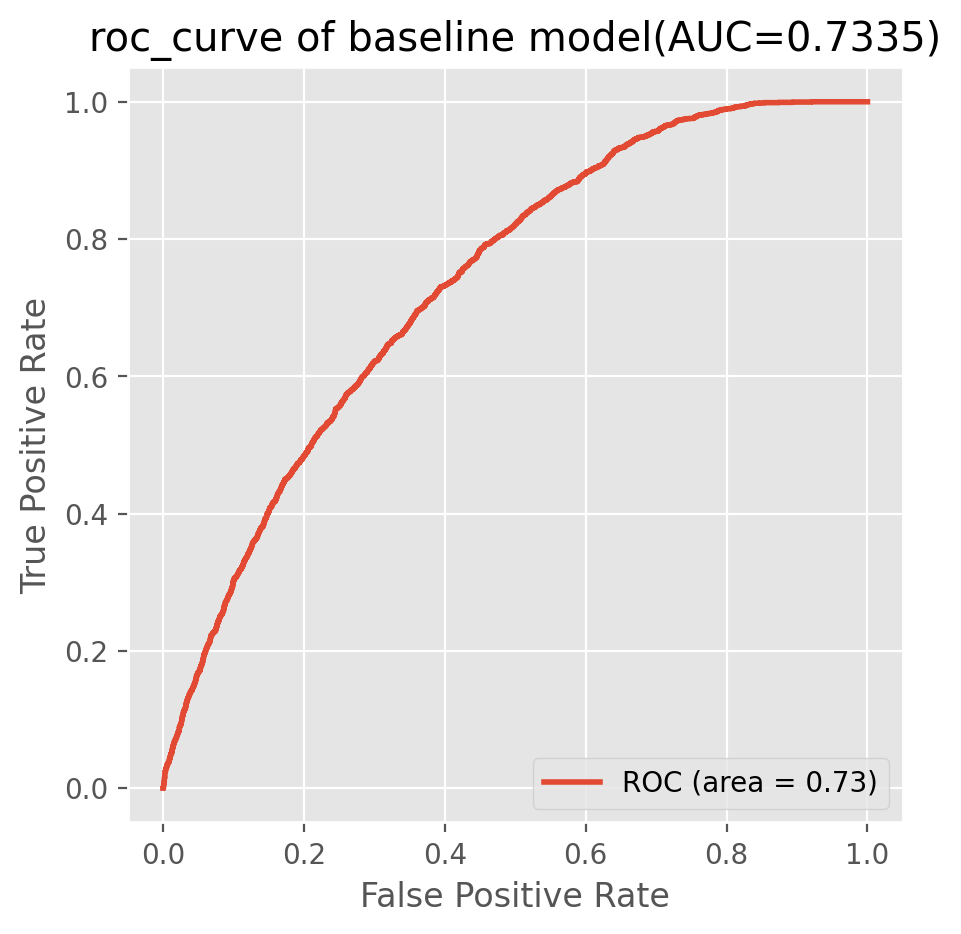

In [167]:
gbm_fpr,gbm_tpr,gbm_threasholds=roc_curve(test.iloc[:,1],test.iloc[:,2]) # 计算ROC的值,svm_threasholds为阈值

roc_auc = auc(gbm_fpr, gbm_tpr)

plt.figure(figsize=(5, 5))
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.title("roc_curve of %s(AUC=%.4f)" %('baseline model',roc_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(gbm_fpr,gbm_tpr, label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
plt.legend(loc="lower right")
plt.savefig("baseline_roc.png")

In [ ]:
df_importance = pd.concat(df_importance_list)
df_importance = df_importance.groupby(['column'])['importance'].agg('mean').sort_values(ascending=False).reset_index()

df_importance_top20 = df_importance.sort_values(by="importance", ascending=False).iloc[0:20,:]
df_importance_top100 = df_importance.sort_values(by="importance", ascending=False).iloc[0:100,:]
# print(df_importance_top100.iloc[:,0].tolist())

In [ ]:
# feature importance visualization

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
# feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 15))
sns.barplot(x="importance", y="column", data=df_importance_top20, palette='Blues' ) 
# plt.title('LightGBM Features (avg over folds)')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 200
plt.xlabel('Importance')
plt.ylabel('Features')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
# plt.show()
plt.savefig('xgb_importances.png')